# PyKasso Examplee
Model Setup of Birk (2002), see pp.77-79

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns

import os
import glob
import shutil

import CFPy as cfpy
import flopy as flopy
import flopy.utils.binaryfile as bf
import pykasso as pk

# using the CFPv2 here, which does support CADS
# to change, type in the correct CFP version for exe_name
path_to_exe = "C:/WRDAPP/CFPv2.exe"

## Define Helper functions

In [2]:
def position_to_index(x, y):
    """
    Get the modflow (!) based index for a given geo position
    
    Keyword Arguments
    x -- x position, m
    y -- y position, m
    
    Return
    column index, row index
    """
    
    col_idx = np.floor(x / delr) + 1
    row_idx = n_rows - np.floor(y / delc)
    
    return col_idx, row_idx

def store_results(number):
    """
    Create a directory and put the current results there
    
    Keyword Arguments
    number -- identifier of the current iteration, float or int
    
    Return
    -
    """
    
    # define directory where to store the results
    target_dir = os.path.join(path, f"run_{number}")
    
    # make sure the directory does not exist
    if os.path.exists(target_dir):
        raise Exception(f"Directory {target_dir} exists already! Unable to write results")
        
    # create directory
    os.makedirs(target_dir)
    
    # get alle files that will be moved
    files_to_move = glob.glob("NODE*") + glob.glob("TUBE*") \
                    + [f"{modelname}.list", f"{modelname}.hds", f"{modelname}.cbc"] \
                    + [f"network_{number}.png"] \
                    + glob.glob("*.nbr") + glob.glob("*.coc") + glob.glob("*.cfp") + glob.glob("*.crch")
    
    # move files to directory
    for f in files_to_move:
        source = os.path.join(path, f)
        destination = os.path.join(target_dir, f)
        shutil.move(source, destination)

def clean_results():
    """
    Remove all run-dictionaries
    
    Keyword Arguments
    -
    
    Return
    -
    """    
    run_dirs = glob.glob(os.path.join(path, "run_*"))    
    for rd in run_dirs:
        shutil.rmtree(rd)
        
def plot_network(valid_network, number):
    """
    Plot and save valid network array as png
    
    Keyword Arguments
    valid_network -- valid network array
    number -- identifier of the current iteration, float or int
    
    Return
    -
    """
    
    # create a figure 
    fig = plt.figure(figsize=(10, 10))
    
    # plot the array
    im = plt.imshow(valid_network)
    cb = plt.colorbar(im, shrink=0.3)
    
    # set descriptions
    plt.xlabel("Spaltenindex", size=14)
    plt.ylabel("Reihenindex", size =14)
    cb.set_label("Höhe, m", size=14)
    
    # save figure
    plt.savefig(f'network_{number}.png')

## Set Up Generic Model

### Path and Model

In [3]:
""" create model object """

# change active directory to model directory

# FIXME: Notation here works for Linux. Notation on Github works for windows.
# Make package system independend by using for example os.path.join everywhere
path = os.getcwd() + "/"
path = os.path.join(os.getcwd(), "CFPy_EX08_RUN")
os.chdir(path)

# path to yaml file
yaml_file = os.path.join(path, "settings6.yaml")

# set model name
modelname = "pyKasso_example"

mf = flopy.modflow.Modflow(modelname, exe_name=path_to_exe)

### Given Variables

In [4]:
""" define general domain characteristics """
# NOTE: n_rows, n_cols, n_lays needs to be the same as specified in the .nbr-file!

# number of rows in the domain
n_rows = 15

# number of columns in the domain
n_cols = 35

# number of layers in the domain
n_lays = 1

# width of each cell along rows, m
delr = 50.0

# width of each cell along columns, m
delc = 50.0

# layer elevations [top, bottom], [m, m]
lay_elevs = [1000.,0.]


""" hydraulic characteristics """
# horizontal hydraulic conductivity of the porous matrix, m/s
hk = 1E-4

# vertical hydraulic conductivity, m/s
vka = hk


""" time discretization """
# time units: 1=seconds, 2=minutes, 3=hours, 4=days
time_unit = 1

# define number of stress periods
n_pers = 1

# length (number of steps) of stress periods
# this variable assumes a uniform time discretization, i.e. all stress periods
# have the same number of time steps except the first stationary time step
perlen = 1

# number of time steps in each stress period (integer array)
# e.g., [1, 50, 50, 70, 33, ...]
n_stps = [perlen]

# list with "False" everywhere except 0th element (which is "True")
#     to specify steady state ("True") or transient ("False")
#     stress periods
steady = [1]


""" boundary conditions """
# recharge to WHOLE AREA, mm/a
recharge_wholearea = 316

# defined head of leftmost column, m
chb_left = 1.0

# defined head at spring node, m
chb_spring = 1.0

# matrix starting head, m
H_init = 2.0


""" solver tolerances """
# modflow general tolerance
mftol = 1e-3

# modflow relaxation parameter
mfrelax = 0.99

# CFP general tolerance
cfptol = 1e-6

# CFP relaxation parameter
cfprelax = 0.99


""" CFP variables """
# geo position of spring, only change with settings.yaml!
x_spring = 0
y_spring = 375

# elevation of all nodes, m
elev_nodes = 1.

# pipe diameter, m
diameter = 0.2

# pipe tortuosity
tortuosity = 1.

# roughness height, m
rheight = 0.02

# lower critical reynolds number
lcritrey = 1000

# higher critical reynolds number
hcritrey = 3000

# conduit wall conductivity, m^2/s
k_exchange = 0.1

# conduit associated storage (CADS), m
cad = 0.00

### Derived Variables

In [5]:
# Get the modflow indices for spring
col_idx_spring, row_idx_spring = position_to_index(x_spring, y_spring)
idxs_spring = [int(col_idx_spring), int(row_idx_spring), 1]

# Compute total length along x
Lx = n_cols*delr
# Compute total length along y
Ly = n_rows*delc

# expand elevations to array
lay_elevs_array = [np.ones((n_rows, n_cols)) * lay_elevs[0],
                   np.ones((n_rows, n_cols)) * lay_elevs[1]]

# Scale recharge so that the total volume is the same as in Birk 2002
recharge = recharge_wholearea * (delc * delr * n_cols * n_rows) / (delc * delr * (n_cols - 1) * n_rows)

### Instantiate Modflow Modules 

In [6]:
""" DIS """
# Create dis object
dis = flopy.modflow.ModflowDis(mf, n_lays, n_rows, n_cols, n_pers, delr, delc, 
                               top=lay_elevs[0], botm=lay_elevs[1],
                               perlen=perlen, nstp=n_stps, steady=steady,
                               itmuni=time_unit, lenuni=2)

""" BAS6 """
# if ibound < 0: constant head, if = 0: inactive, if > 0: active.
# create arrays to indicate active cells (ibound) and starting heads (H_init)

# integer array of dim (z,y,x), makes all cells active 
ibound = np.ones((n_lays, n_rows, n_cols), dtype=np.int32)

# replace leftmost column with -1 to indicate constant head 
ibound[:,:,0] = -1

# initialize starting head array
H_init_array = np.ones((n_lays, n_rows, n_cols), dtype=np.float32)
# assign starting head values to all cells
H_init_array[:,:,:] = H_init
# assign constant head value to leftmost column
H_init_array[:,:,0] = chb_left

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=H_init)

""" LPF """
#unit number to save outputs to
ipakcb = 50
#value assigned to dry cells
hdry = 999.
#0=confined, >0 = unconfined/convertible
laytyp = 1
#method of calculating interblock tranmissivity, 0=harmonic mean (default)
layavg = 0
#horizontal anisotropy (ratio of Ky (along cols) to Kx (along rows)
chani = 1
#indicates vka = Kz
layvka = 0
#wetting, 0=inactive, 1=active
laywet = 0

lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, chani=chani, layvka=layvka, laywet=laywet, 
            ipakcb=ipakcb, hdry=hdry, hk=hk, hani=chani, vka=vka, wetdry=laywet)

""" OC """
# create dictionary
per_dict = {(0,0):['print head', 'save head', 'save budget']}

# create output control file using dictionary
oc = flopy.modflow.ModflowOc(mf, stress_period_data=per_dict)

""" PCG """
#max number of outer iterations
mxiter = 2000
#number of inner iterations
iter1 = 2000
#flag for matrix conditioning method, 1=modified incomplete cholesky
npcond = 1
#flag for active cell surrounded by dry cells. 0=converts to dry, not0=converts only if hcof=0
ihcofadd = 9999
#relaxation parameter with npcond=1
relax = mfrelax
#estimate of upper bound
nbpol = 2
#printout interval
iprpcg = 5
#print flag, 5=?
mutpcg = 0
#damping factor
damppcg = 0.99

pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, iter1=iter1, npcond=npcond, hclose=mftol, rclose=mftol, 
                               relax=relax, nbpol=nbpol, iprpcg=iprpcg, mutpcg=mutpcg, damp=damppcg,
                               ihcofadd=ihcofadd)

""" RCH """
# flag, 1=rech only applied to top layer
nrchop = 1
# if non-zero, cell budget data will be saved
ipakcb = 50

# recharge from mm/a to m/s
recharge_si = recharge / (365.25 * 24 * 60 * 60 * 1000)

# dictionary of recharge fluxes for each stress period
rech = {0:recharge_si}

rch = flopy.modflow.mfrch.ModflowRch(mf, nrchop=nrchop, ipakcb=ipakcb, rech=rech)

## Remove pririor results

In [7]:
clean_results()

## Run loop

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.
Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.02 s
FloPy is using the following executable to run the model: C:/WRDAPP/CFPv2.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.25 06/04/2013 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: pyKasso_example.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 202

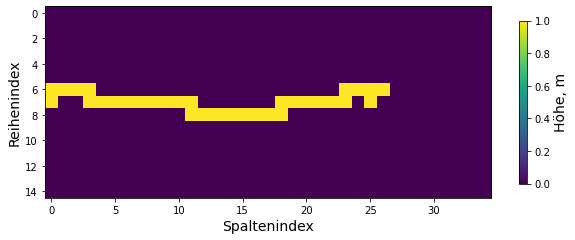

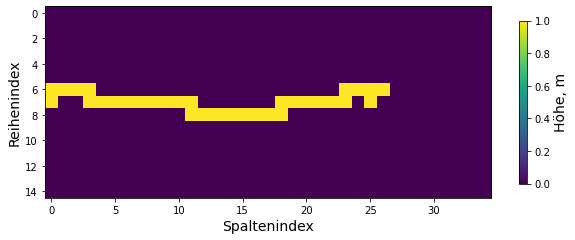

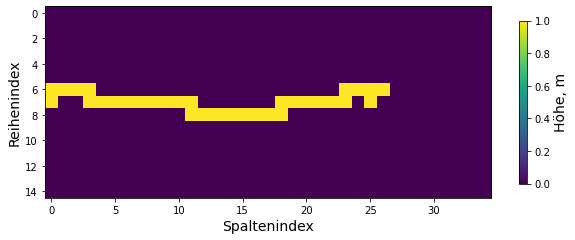

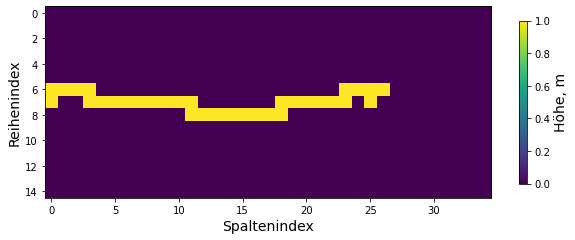

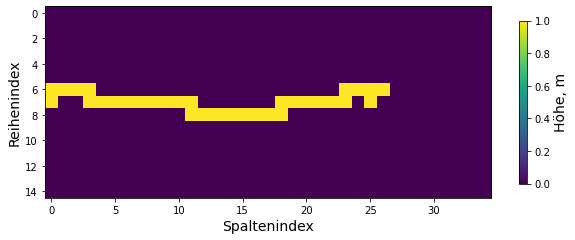

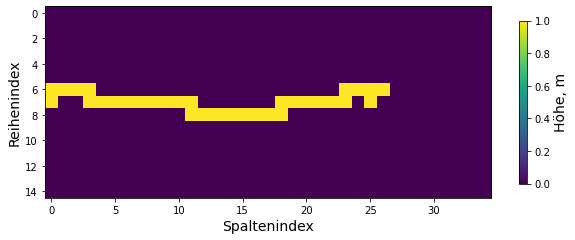

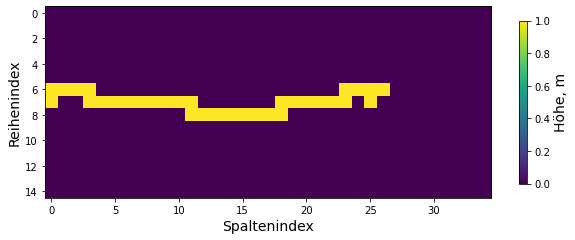

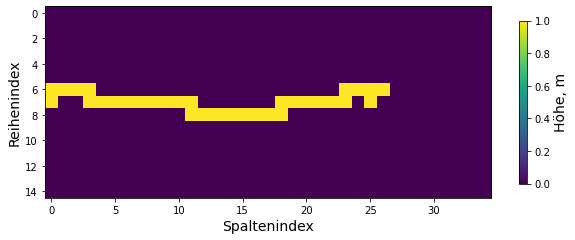

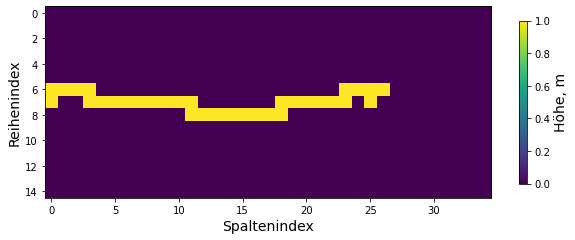

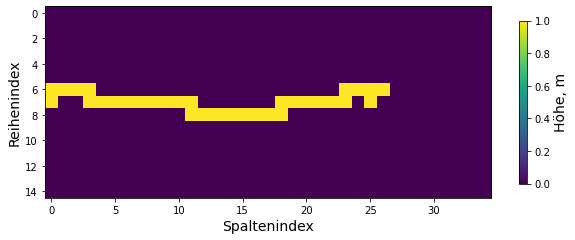

In [8]:
valid_networks = []
head_results = []

for i in range(10):
    mf.write_input()
    
    k_exchange_list = np.linspace(0.001, 1., 10, endpoint=True)
    
    """ Create Network """
    # read in settings file
    catchment = pk.SKS(yaml_settings_file=yaml_file)
    
    # compute karst networks from the given information
    catchment.compute_karst_network()

    # generate elevation data
    # NOTE: elevation data has to have the same shape as the node network array!
    shp = np.array(catchment.karst_simulations[-1].maps['karst'][-1]).shape
    # Set elevation of all nodes
    elevs = np.ones(shp) * elev_nodes
    # validate the network from pyKasso
    validator = cfpy.preprocessing.pyKassoValidator(network=catchment, elevations=elevs)
    valid_network = validator.validate_network()
    
    # export the network
    # the exported information can directly be included in the .nbr-file as input for CFPy
    # notes on how to use the generated data with CFPy is given at the end of the notebook
    # per default, the network is exported to "CFPy_exported_network_for_NBR.txt" in the active directory
    validator.export_network()
    
    """ Generate NBR """
    # generate nbr file
    validator.generate_nbr(
        path = path,
        nrows = n_rows,
        ncols = n_cols,
        nlays = n_lays,
        nplanes = 1,
        layer_elevations = lay_elevs_array
    )
    
    """ Create NBR """
    # create nbr object
    nbr = cfpy.nbr()

    # read model layer/node and conduit layer/node elevations

    # bot_elev has shape (n_layers, n_rows, n_cols)
    # cond_elev has shape (n_conduit_layers, n_rows, n_cols)
    # function looks for an .nbr-file, if none or more than one file is found, an error is raised
    # make sure to only have one .nbr-file in the working directory
    bot_elev, cond_elev = nbr.nbr_read()

    # create nbr data
    nbr_data = nbr.nbr(bot_elev, cond_elev)
    
    """ Pipe Flow Parameter """
    # diameter
    p_diameter = np.ones(len(nbr_data[5])) * diameter
    p_diameter = p_diameter.tolist()

    # tortuosity
    p_tortuosity = np.ones(len(nbr_data[5])) * tortuosity
    p_tortuosity = p_tortuosity.tolist()

    # roughness height
    p_rheight = np.ones(len(nbr_data[5])) * rheight
    p_rheight = p_rheight.tolist()

    # lower critical reynolds number
    p_lcritrey = np.ones(len(nbr_data[5])) * lcritrey
    p_lcritrey = p_lcritrey.tolist()

    # higher critical reynolds number
    p_hcritrey = np.ones(len(nbr_data[5])) * hcritrey
    p_hcritrey = p_hcritrey.tolist()

    # summarize all data in a 2D-array
    pipe_data = [nbr_data[5], p_diameter, p_tortuosity, p_rheight, p_lcritrey, p_hcritrey]
    
    """ Node Heads """
    # parametrization for all n nodes
    # if head > 0: fixed head
    # if head == -1: calculated head
    n_head = np.ones((len(nbr_data[0]))) * -1
    n_head = n_head.tolist()

    # search if the spring exists in the nodes
    if idxs_spring in nbr_data[2]:
        # get the position of spring node inside nbr_data
        pos = nbr_data[2].index(idxs_spring)
        # assign the head to spring node
        n_head[pos] = chb_spring
    else:
        raise Exception("Cannot find indices of spring in the indices of nodes!")

    node_data = [nbr_data[0], n_head]
    
    """ KEX Data """
    kex_data = [nbr_data[0],
                np.ones(len(nbr_data[0])) * k_exchange_list[i]]
    
    """ CADS Data """
    cads_data = np.ones((len(nbr_data[0]))) * cad
    cads_data = cads_data.tolist()
    
    """ Instantiate CFP """
    cfp = cfpy.cfp(mode = 1,
                   nnodes = len(nbr_data[0]), 
                   npipes = len(nbr_data[5]), 
                   nlay = n_lays, 
                   nbr_data = nbr_data, 
                   geoheight = cond_elev, 
                   sa_exchange = 0, 
                   epsilon = cfptol,
                   niter = 2000, 
                   relax = cfprelax, 
                   p_nr = 0, 
                   cond_data = pipe_data, 
                   n_head = node_data, 
                   k_exchange = kex_data, 
                   ncl = 0, 
                   cl = 0, 
                   ltemp = 10,
                   condl_data = 0,
                   cads = cads_data)

    # create list of strings
    cfp = cfp.cfp()
    
    """ COC """
    coc = cfpy.coc(nnodes = len(nbr_data[0]),
                   node_numbers = nbr_data[0],
                   n_nts = 1,
                   npipes = len(nbr_data[5]), 
                   pipe_numbers = nbr_data[5],
                   t_nts = 1)

    coc = coc.coc()
    
    """ CRCH """
    # p_crch is list of length (n_nodes) specifying the direct recharge fraction for each node
    # initially set p_crch to 0 for all nodes (no direct recharge)
    p_crch = np.zeros((len(nbr_data[0]))).tolist()

    crch = cfpy.crch(iflag_crch = 1, 
                     nper = n_pers, 
                     node_numbers = nbr_data[0], 
                     p_crch = p_crch)

    # create list of strings
    crch = crch.crch()
    
    """ Write Input """
    input_files = cfpy.write_input(modelname = modelname,
                                   data_strings = [coc, crch, cfp],
                                   file_extensions = ['coc', 'crch', 'cfp'])

    # write CFP input files
    input_files.write_input()
    
    """ Update nam file """
    nam = cfpy.update_nam(modelname = modelname,
                          mode = 1,
                          cfp_unit_num = 52,
                          crch_unit_num = 53,
                          coc_unit_num = 54)

    # update existing .nam file
    nam.update_nam()
    
    """ Run model """
    success, buff = mf.run_model(silent=False)
    
    if success:
        valid_networks.append(valid_network)
        plot_network(valid_network, i)
        
        store_results(i)

## Post-Processing


### Read in heads

In [9]:
# get all dictionaries with results
run_dirs = glob.glob(os.path.join(path, "run_*"))
# sort in place
run_dirs.sort()

head_list = []
budget_list = []
for rd in run_dirs:
    print(f"Directory {rd}")
    # lst file name
    lst_file = os.path.join(rd, f"{modelname}.list")
    # read lst file
    lst = flopy.utils.MfListBudget(lst_file)
    # get budget
    budget = lst.get_data(totim=1)
    
    # hds file name
    hds_file = os.path.join(rd, f"{modelname}.hds")
    # read hds file
    hds = bf.HeadFile(hds_file)
    # get head
    head = hds.get_data(totim=1)
    # add to head list
    head_list.append(head)

total_head = np.concatenate(head_list)
    

Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX08_RUN\run_0
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX08_RUN\run_1
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX08_RUN\run_2
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX08_RUN\run_3
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX08_RUN\run_4
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Direc

### Plot exemplary head

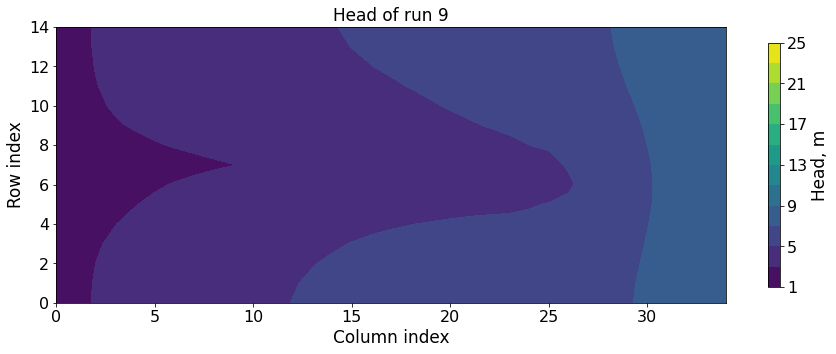

In [10]:
run_idx = 0 

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
im = plt.contourf(total_head[run_idx,:,:], 
                  #levels=np.linspace(np.min(total_head[run_idx,:,:]), np.max(total_head[run_idx,:,:]), 10))
                  levels=np.arange(1, 27, 2))
cb = fig.colorbar(im, shrink=0.3)

cb.set_label("Head, m", size=17)
run_number = rd.replace(os.path.join(path, "run_"), "")
plt.title(f"Head of run {run_number}", size=17) #{np.sum(success_runs)}
plt.xlabel("Column index", size=17)
plt.ylabel("Row index", size =17)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
cb.ax.tick_params(labelsize=16)

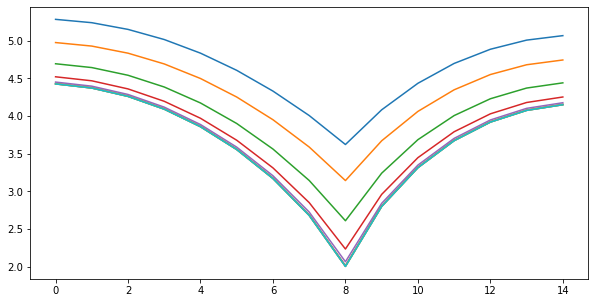

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(len(valid_networks)):
    ax.plot(total_head[i, :, 15])

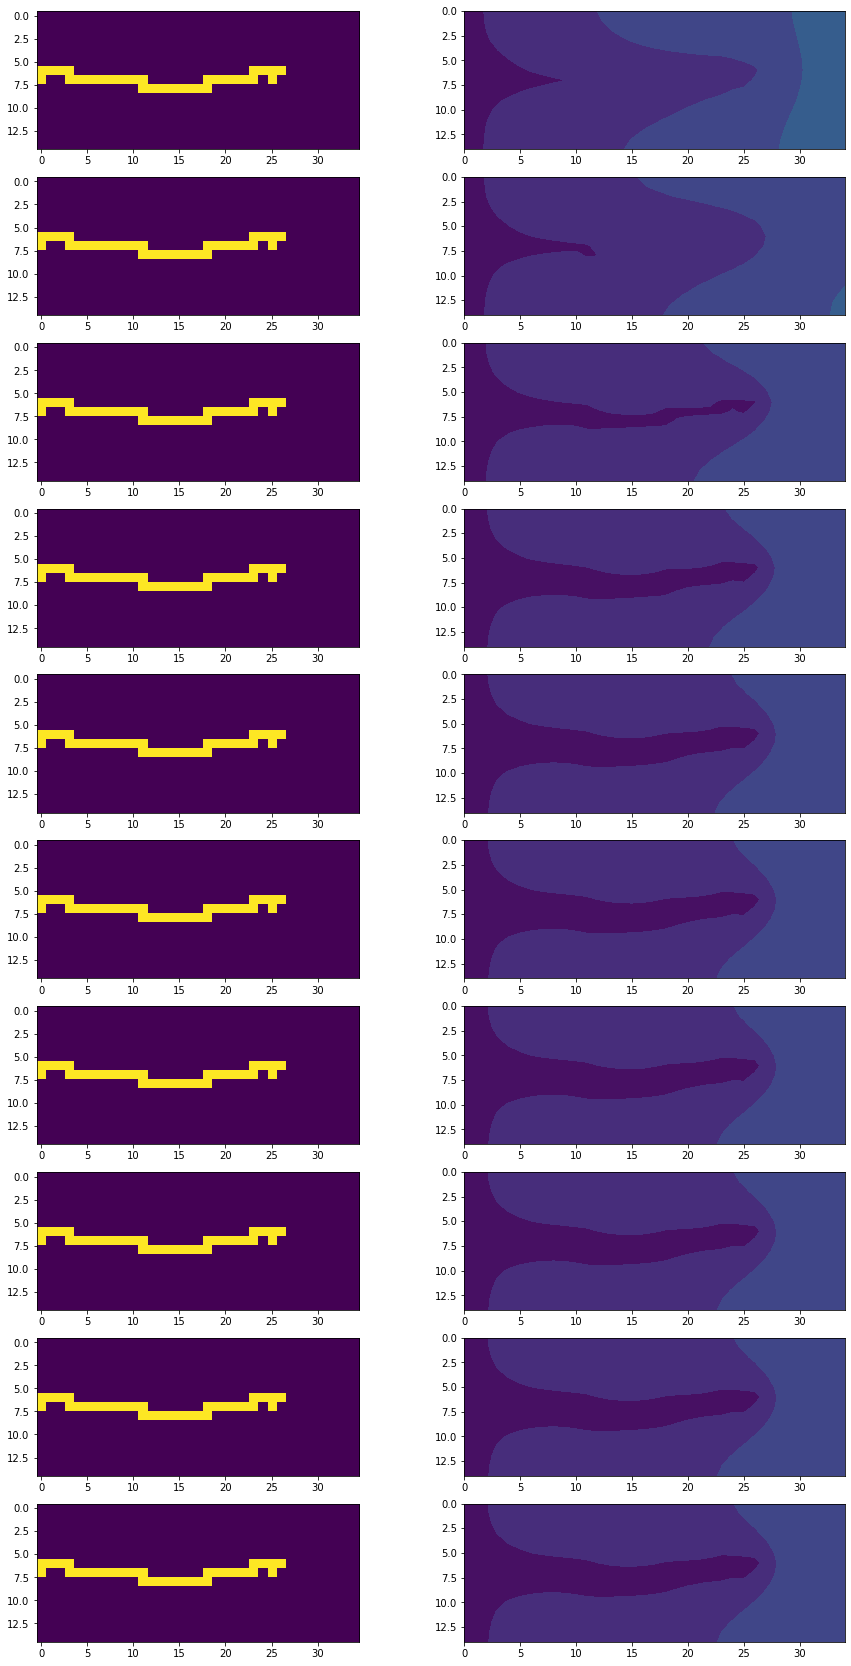

In [12]:
fig, ax = plt.subplots(nrows=len(valid_networks), ncols=2, figsize=(15, 3 * len(valid_networks)))

for i in range(len(valid_networks)):
    ax[i, 0].imshow(valid_networks[i])
    im = ax[i, 1].contourf(total_head[i, :, :], levels=np.arange(1, 27, 2))
    ax[i, 1].invert_yaxis()
    # cb = plt.colorbar(im, shrink=0.6, ax=ax[i, 1])

### Plot standard deviation of head

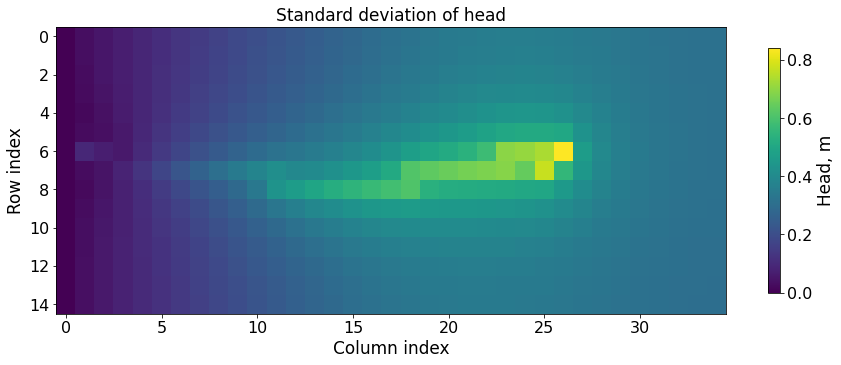

In [13]:
run_idx = 0 

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
#ctr = ax.contourf(var_head, levels=np.linspace(np.min(var_head), np.max(var_head), 200))
im = plt.imshow(np.std(total_head[:,:,:], axis=0))
cb = fig.colorbar(im, shrink=0.3)

cb.set_label("Head, m", size=17)
run_number = rd.replace(os.path.join(path, "run_"), "")
plt.title(f"Standard deviation of head", size=17) #{np.sum(success_runs)}
plt.xlabel("Column index", size=17)
plt.ylabel("Row index", size =17)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
cb.ax.tick_params(labelsize=16)